# Research In Computing - Demand Forecasting

## Applying Recurrent Neural Network

Task: The dataset (Historical Product Demand.csv) contains the 6 years of order demand observations from many locations for multiple products. The goal is to develop a model to predict the demand for particular product.

We will be following this example step-by-step in this assessment:
1. Importing the libraries
1. Loading the data
1. Cleaning the data
1. Analyzing the dataset
1. Sequential models have 3 dimension (sample size, time steps, features). We use TimeSeriesGenerator class which to convert data to 3-Dimensional
1. Simle RNN has been applied on the data.
1. Analyzing the model performance

In [1]:
# Importing Libraries
import pandas as pd;
import matplotlib.pyplot as plt
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RNN, SimpleRNN
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dropout
# from keras.optimizers import Adam
from keras.layers.core import Activation
from keras.callbacks import LambdaCallback
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam

In [2]:
#Import the data and parse dates.
dataset  = pd.read_csv('Historical Product Demand.csv', parse_dates=['Date'])
dataset.head()

Product_Code Warehouse Product_Category       Date Order_Demand
0  Product_0993    Whse_J     Category_028 2012-07-27         100 
1  Product_0979    Whse_J     Category_028 2012-01-19         500 
2  Product_0979    Whse_J     Category_028 2012-02-03         500 
3  Product_0979    Whse_J     Category_028 2012-02-09         500 
4  Product_0979    Whse_J     Category_028 2012-03-02         500

### Encoding string values to numerical

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dataset['Product_Code'] = le.fit_transform(dataset['Product_Code'])
dataset['Warehouse'] = le.fit_transform(dataset['Warehouse'])
dataset['Product_Category'] = le.fit_transform(dataset['Product_Category'])


### Splitting Date Time

In [4]:
dataset['Year'] = dataset['Date'].dt.year
dataset['Month'] = dataset['Date'].dt.month
dataset['Day'] = dataset['Date'].dt.day
dataset.drop(['Date'], axis=1, inplace = True)
dataset

Product_Code  Warehouse  Product_Category Order_Demand    Year  \
0                 982          2                27         100   2012.0   
1                 968          2                27         500   2012.0   
2                 968          2                27         500   2012.0   
3                 968          2                27         500   2012.0   
4                 968          2                27         500   2012.0   
...               ...        ...               ...          ...     ...   
1048570          1780          2                 5        1000   2016.0   
1048571          1962          2                 5           1   2016.0   
1048572          1776          2                 5        2500   2016.0   
1048573           890          2                22          50   2016.0   
1048574           703          2                 0           4   2016.0   

         Month   Day  
0          7.0  27.0  
1          1.0  19.0  
2          2.0   3.0  
3          2.0   9.0  
4          3.0   2.0  
...        ...   ...  
1048570    4.0  27.0  
1048571    4.0  27.0  
1048572    4.0  28.0  
1048573   10.0   7.0  
1048574    6.0  27.0  

[1048575 rows x 7 columns]

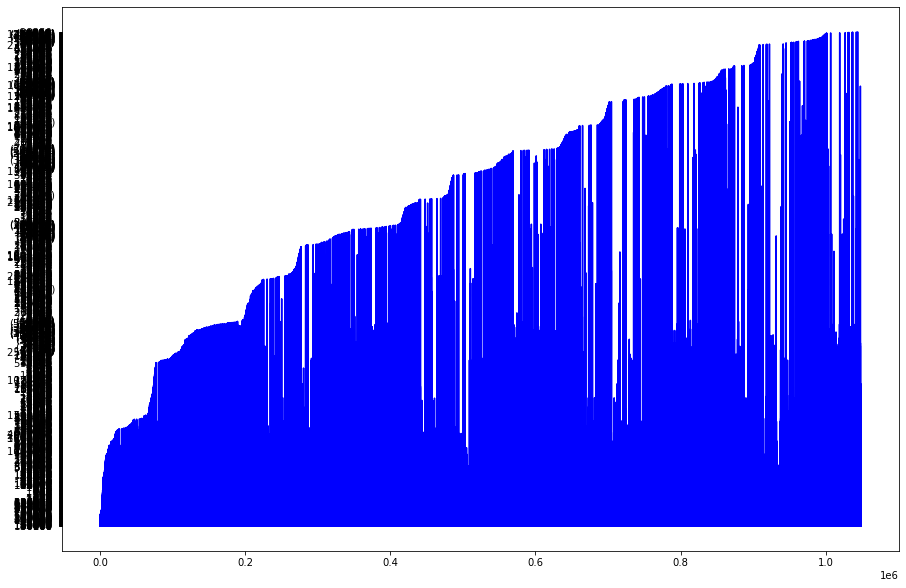

In [5]:
plt.figure(figsize=(15,10))
plt.plot(dataset['Order_Demand'], color='blue')
plt.show()

In [6]:
dataset.head()


Product_Code  Warehouse  Product_Category Order_Demand    Year  Month   Day
0           982          2                27         100   2012.0    7.0  27.0
1           968          2                27         500   2012.0    1.0  19.0
2           968          2                27         500   2012.0    2.0   3.0
3           968          2                27         500   2012.0    2.0   9.0
4           968          2                27         500   2012.0    3.0   2.0

In [7]:
dataset['Product_Code'] = dataset['Product_Code'].astype(float)
dataset['Warehouse'] = dataset['Warehouse'].astype(float)
dataset['Product_Category'] = dataset['Product_Category'].astype(float)
dataset['Order_Demand'] = le.fit_transform(dataset['Order_Demand'])
dataset['Order_Demand'] = dataset['Order_Demand'].astype(float)

In [8]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Product_Code      1048575 non-null  float64
 1   Warehouse         1048575 non-null  float64
 2   Product_Category  1048575 non-null  float64
 3   Order_Demand      1048575 non-null  float64
 4   Year              1037336 non-null  float64
 5   Month             1037336 non-null  float64
 6   Day               1037336 non-null  float64
dtypes: float64(7)
memory usage: 56.0 MB
None


### In this case we are using different approach, Filling null values with mode

In [9]:
dataset.isnull().any()
dataset['Year'] = dataset['Year'].fillna(dataset['Year'].mode()[0])
dataset['Month'] = dataset['Month'].fillna(dataset['Month'].mode()[0])
dataset['Day'] = dataset['Day'].fillna(dataset['Day'].mode()[0])

### Splitting data into train, test and hold-out data

In [10]:
number_of_test_data = 5000
number_of_holdout_data = 5000
number_of_training_data = len(dataset) - number_of_holdout_data - number_of_test_data
print ("total, train, test, holdout:", len(dataset), number_of_training_data, number_of_test_data, number_of_holdout_data)

total, train, test, holdout: 1048575 1038575 5000 5000


In [11]:
datatrain = dataset[:number_of_training_data]
datatest = dataset[-(number_of_test_data+number_of_holdout_data):-number_of_holdout_data]
datahold = dataset[-number_of_holdout_data:]

### Preparing 3-Dimensional Input for Sequential Model

In [12]:
in_seq1 = array(datatrain['Product_Code'])
in_seq2 = array(datatrain['Warehouse'])
in_seq3 = array(datatrain['Product_Category'])
in_seq4 = array(datatrain['Year'])
in_seq5 = array(datatrain['Month'])
in_seq6 = array(datatrain['Day'])
out_seq_train = array(datatrain['Order_Demand'])

In [13]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
out_seq_train = out_seq_train.reshape((len(out_seq_train), 1))

In [14]:
datatrain_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, out_seq_train))

In [15]:
in_seq1 = array(datatest['Product_Code'])
in_seq2 = array(datatest['Warehouse'])
in_seq3 = array(datatest['Product_Category'])
in_seq4 = array(datatest['Year'])
in_seq5 = array(datatest['Month'])
in_seq6 = array(datatest['Day'])
out_seq_test = array(datatest['Order_Demand'])

In [16]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
out_seq_test = out_seq_test.reshape((len(out_seq_test), 1))

In [17]:
datatest_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, out_seq_test))

In [18]:
in_seq1 = array(datahold['Product_Code'])
in_seq2 = array(datahold['Warehouse'])
in_seq3 = array(datahold['Product_Category'])
in_seq4 = array(datahold['Year'])
in_seq5 = array(datahold['Month'])
in_seq6 = array(datahold['Day'])
out_seq_hold = array(datahold['Order_Demand'])
# out_seq_hold = np.array([np.array(cv2.imread(imagePaths[i])) for i in range(len(imagePaths))])

In [19]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
out_seq_hold = out_seq_hold.reshape((len(out_seq_hold), 1))

In [20]:
datahold_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, out_seq_hold))

In [21]:
n_features = datatrain_feed.shape[1]
n_input = 10
generator_train = TimeseriesGenerator(datatrain_feed, out_seq_train, length=n_input, batch_size=len(datatrain_feed))

In [22]:
for i in range(len(generator_train)):
    x, y = generator_train[i]
    print('%s => %s' % (x, y))

[[[9.820e+02 2.000e+00 2.700e+01 ... 7.000e+00 2.700e+01 5.430e+02]
  [9.680e+02 2.000e+00 2.700e+01 ... 1.000e+00 1.900e+01 2.847e+03]
  [9.680e+02 2.000e+00 2.700e+01 ... 2.000e+00 3.000e+00 2.847e+03]
  ...
  [9.680e+02 2.000e+00 2.700e+01 ... 6.000e+00 2.700e+01 2.847e+03]
  [9.680e+02 2.000e+00 2.700e+01 ... 7.000e+00 2.300e+01 2.847e+03]
  [9.680e+02 2.000e+00 2.700e+01 ... 8.000e+00 2.900e+01 2.847e+03]]

 [[9.680e+02 2.000e+00 2.700e+01 ... 1.000e+00 1.900e+01 2.847e+03]
  [9.680e+02 2.000e+00 2.700e+01 ... 2.000e+00 3.000e+00 2.847e+03]
  [9.680e+02 2.000e+00 2.700e+01 ... 2.000e+00 9.000e+00 2.847e+03]
  ...
  [9.680e+02 2.000e+00 2.700e+01 ... 7.000e+00 2.300e+01 2.847e+03]
  [9.680e+02 2.000e+00 2.700e+01 ... 8.000e+00 2.900e+01 2.847e+03]
  [9.680e+02 2.000e+00 2.700e+01 ... 8.000e+00 2.900e+01 2.847e+03]]

 [[9.680e+02 2.000e+00 2.700e+01 ... 2.000e+00 3.000e+00 2.847e+03]
  [9.680e+02 2.000e+00 2.700e+01 ... 2.000e+00 9.000e+00 2.847e+03]
  [9.680e+02 2.000e+00 2.700e+01

In [23]:
generator_test = TimeseriesGenerator(datatest_feed, out_seq_test, length=n_input, batch_size=1)

In [24]:
for i in range(len(generator_test)):
    x, y = generator_test[i]
    print('%s => %s' % (x, y))

[[[2.540e+02 2.000e+00 6.000e+00 2.016e+03 4.000e+00 2.500e+01 2.152e+03]
  [2.520e+02 2.000e+00 6.000e+00 2.016e+03 4.000e+00 2.600e+01 2.402e+03]
  [3.600e+02 2.000e+00 6.000e+00 2.016e+03 4.000e+00 2.700e+01 5.410e+02]
  [3.600e+02 2.000e+00 6.000e+00 2.016e+03 4.000e+00 2.700e+01 5.410e+02]
  [2.540e+02 2.000e+00 6.000e+00 2.016e+03 4.000e+00 2.800e+01 3.313e+03]
  [4.110e+02 2.000e+00 6.000e+00 2.016e+03 5.000e+00 2.000e+00 1.557e+03]
  [1.875e+03 2.000e+00 6.000e+00 2.016e+03 4.000e+00 2.800e+01 5.430e+02]
  [3.600e+02 2.000e+00 6.000e+00 2.016e+03 4.000e+00 2.800e+01 2.152e+03]
  [1.113e+03 2.000e+00 6.000e+00 2.016e+03 4.000e+00 2.800e+01 2.543e+03]
  [1.990e+02 2.000e+00 6.000e+00 2.016e+03 4.000e+00 2.800e+01 2.152e+03]]] => [[2152.]]
[[[2.520e+02 2.000e+00 6.000e+00 2.016e+03 4.000e+00 2.600e+01 2.402e+03]
  [3.600e+02 2.000e+00 6.000e+00 2.016e+03 4.000e+00 2.700e+01 5.410e+02]
  [3.600e+02 2.000e+00 6.000e+00 2.016e+03 4.000e+00 2.700e+01 5.410e+02]
  [2.540e+02 2.000e+00 

In [25]:
generator_hold = TimeseriesGenerator(datahold_feed, out_seq_hold, length=n_input, batch_size=1)

In [26]:
for i in range(len(generator_hold)):
    x, y = generator_hold[i]
    print('%s => %s' % (x, y))

[[[1.208e+03 2.000e+00 1.800e+01 2.016e+03 6.000e+00 2.000e+00 1.560e+03]
  [1.618e+03 2.000e+00 1.800e+01 2.016e+03 4.000e+00 2.600e+01 1.559e+03]
  [1.618e+03 2.000e+00 1.800e+01 2.016e+03 5.000e+00 1.200e+01 5.430e+02]
  [1.202e+03 2.000e+00 1.800e+01 2.016e+03 4.000e+00 2.500e+01 5.430e+02]
  [1.211e+03 2.000e+00 1.800e+01 2.016e+03 4.000e+00 2.500e+01 5.430e+02]
  [1.198e+03 2.000e+00 1.800e+01 2.016e+03 5.000e+00 1.300e+01 1.559e+03]
  [1.211e+03 2.000e+00 1.800e+01 2.016e+03 4.000e+00 2.600e+01 5.430e+02]
  [1.211e+03 2.000e+00 1.800e+01 2.016e+03 4.000e+00 2.700e+01 5.430e+02]
  [1.211e+03 2.000e+00 1.800e+01 2.016e+03 4.000e+00 2.800e+01 5.440e+02]
  [1.202e+03 2.000e+00 1.800e+01 2.016e+03 6.000e+00 7.000e+00 5.430e+02]]] => [[543.]]
[[[1.618e+03 2.000e+00 1.800e+01 2.016e+03 4.000e+00 2.600e+01 1.559e+03]
  [1.618e+03 2.000e+00 1.800e+01 2.016e+03 5.000e+00 1.200e+01 5.430e+02]
  [1.202e+03 2.000e+00 1.800e+01 2.016e+03 4.000e+00 2.500e+01 5.430e+02]
  [1.211e+03 2.000e+00 1

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [27]:
print("timesteps, features:", n_input, n_features)

timesteps, features: 10 7


In [28]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(array(dataset['Order_Demand']).reshape(len(dataset['Order_Demand']), 1))
series = pd.DataFrame(scaled)
series.columns = ['Order_Demand']
dataset

Product_Code  Warehouse  Product_Category  Order_Demand    Year  \
0               982.0        2.0              27.0         543.0  2012.0   
1               968.0        2.0              27.0        2847.0  2012.0   
2               968.0        2.0              27.0        2847.0  2012.0   
3               968.0        2.0              27.0        2847.0  2012.0   
4               968.0        2.0              27.0        2847.0  2012.0   
...               ...        ...               ...           ...     ...   
1048570        1780.0        2.0               5.0         544.0  2016.0   
1048571        1962.0        2.0               5.0         541.0  2016.0   
1048572        1776.0        2.0               5.0        1890.0  2016.0   
1048573         890.0        2.0              22.0        2846.0  2016.0   
1048574         703.0        2.0               0.0        2543.0  2016.0   

         Month   Day  
0          7.0  27.0  
1          1.0  19.0  
2          2.0   3.0  
3          2.0   9.0  
4          3.0   2.0  
...        ...   ...  
1048570    4.0  27.0  
1048571    4.0  27.0  
1048572    4.0  28.0  
1048573   10.0   7.0  
1048574    6.0  27.0  

[1048575 rows x 7 columns]

### Creating RNN model

In [32]:
model = Sequential()

model.add(SimpleRNN(4, activation='linear', input_shape=(n_input, n_features), return_sequences = False))
model.add(Dense(1, activation='linear'))

adam = Adam(lr=0.0001)
model.compile(optimizer='adam', loss='mse')

C:\Users\varya\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Training the model

In [33]:
score = model.fit_generator(generator_train, epochs=2000, verbose=2, validation_data=generator_test)

<ipython-input-33-a45cf7894bf8>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  score = model.fit_generator(generator_train, epochs=2000, verbose=2, validation_data=generator_test)


Epoch 1/2000
1/1 - 8s - loss: 5598492.0000 - val_loss: 4540064.0000 - 8s/epoch - 8s/step
Epoch 2/2000
1/1 - 7s - loss: 5345647.5000 - val_loss: 4337165.0000 - 7s/epoch - 7s/step
Epoch 3/2000
1/1 - 7s - loss: 5100613.0000 - val_loss: 4141780.0000 - 7s/epoch - 7s/step
Epoch 4/2000
1/1 - 7s - loss: 4863603.0000 - val_loss: 3954070.0000 - 7s/epoch - 7s/step
Epoch 5/2000
1/1 - 7s - loss: 4634810.0000 - val_loss: 3774198.5000 - 7s/epoch - 7s/step
Epoch 6/2000
1/1 - 7s - loss: 4414403.0000 - val_loss: 3602295.2500 - 7s/epoch - 7s/step
Epoch 7/2000
1/1 - 7s - loss: 4202531.0000 - val_loss: 3438504.5000 - 7s/epoch - 7s/step
Epoch 8/2000
1/1 - 7s - loss: 3999331.7500 - val_loss: 3282919.5000 - 7s/epoch - 7s/step
Epoch 9/2000
1/1 - 7s - loss: 3804930.0000 - val_loss: 3135654.2500 - 7s/epoch - 7s/step
Epoch 10/2000
1/1 - 7s - loss: 3619444.5000 - val_loss: 2996813.5000 - 7s/epoch - 7s/step
Epoch 11/2000
1/1 - 7s - loss: 3442992.7500 - val_loss: 2866480.5000 - 7s/epoch - 7s/step
Epoch 12/2000
1/1 -

In [35]:
df_result = pd.DataFrame({'Actual' : [], 'Prediction' : []})

for i in range(len(generator_test)):
    x, y = generator_test[i]
    x_input = array(x).reshape((1, n_input, n_features))
    yhat = model.predict(x_input, verbose=2)
    df_result = df_result.append({'Actual': scaler.inverse_transform(y)[0][0], 'Prediction': scaler.inverse_transform(yhat)[0][0]}, ignore_index=True)

1/1 - 0s - 122ms/epoch - 122ms/step
1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 12ms/epoch - 12ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 1

### Plot of Training and Test Loss Functions

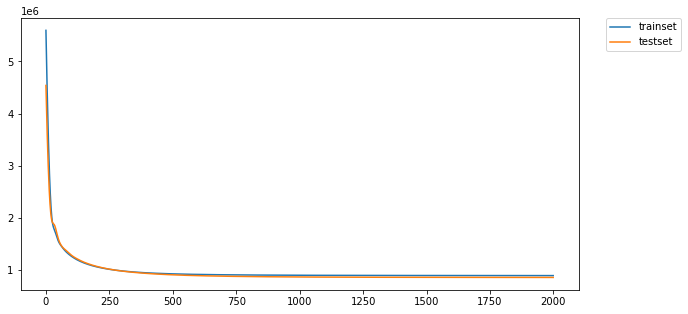

In [36]:
losses = score.history['loss']
val_losses = score.history['val_loss']
plt.figure(figsize=(10,5))
plt.plot(losses, label="trainset")
plt.plot(val_losses, label="testset")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

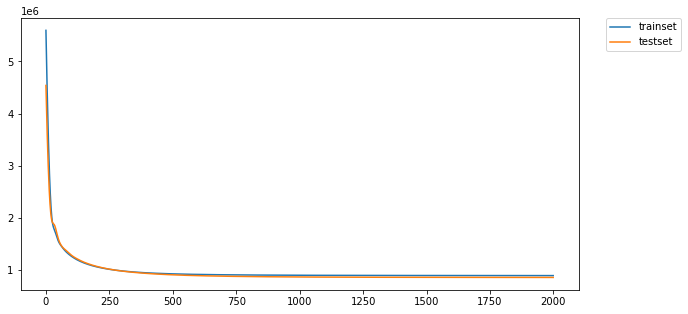

In [37]:
losses = score.history['loss']
val_losses = score.history['val_loss']
plt.figure(figsize=(10,5))
plt.plot(losses, label="trainset")
plt.plot(val_losses, label="testset")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Predictions for Test Data

In [38]:
df_result = df_result.append({'Actual': scaler.inverse_transform(y)[0][0], 'Prediction': scaler.inverse_transform(yhat)[0][0]}, ignore_index=True)

In [39]:
df_result['Diff'] = 100 * (df_result['Prediction'] - df_result['Actual']) / df_result['Actual']

In [40]:
df_result

Actual  Prediction        Diff
0     8235704.0   6433536.0  -21.882379
1     8239531.0   6651820.5  -19.269428
2     5958639.0   7110989.5   19.339156
3     5962466.0   6707374.0   12.493287
4     2074234.0   6772528.0  226.507424
...         ...         ...         ...
4986  2078061.0   5586416.0  168.828297
4987  5966293.0   4940264.0  -17.197094
4988  8247185.0   5500447.0  -33.305158
4989  2078061.0   5870415.5  182.494859
4990  2078061.0   5870415.5  182.494859

[4991 rows x 3 columns]

### Calculating the Correctness for Test Data

In [41]:
mean = df_result['Actual'].mean()
mae = (df_result['Actual'] - df_result['Prediction']).abs().mean()

print("mean: ", mean)
print("mae:", mae)
print("mae/mean ratio: ", 100*mae/mean,"%")
print("correctness: ", 100 - 100*mae/mean,"%")

mean:  5399364.85453817
mae: 3070834.150571028
mae/mean ratio:  56.87398857645247 %
correctness:  43.12601142354753 %


### Plot of Actuals and Predictions for Test Data

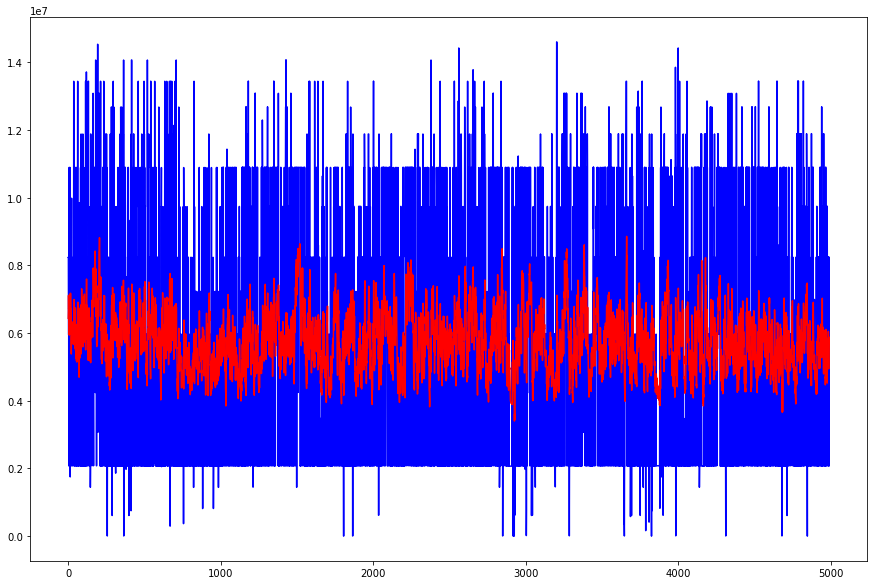

In [43]:
plt.figure(figsize=(15,10))
plt.plot(df_result['Actual'], color='blue')
plt.plot(df_result['Prediction'], color='red')
plt.show()

### Predictions for Hold-Out Data

In [44]:
df_result = pd.DataFrame({'Actual' : [], 'Prediction' : []})

for i in range(len(generator_hold)):
    x, y = generator_hold[i]
    x_input = array(x).reshape((1, n_input, n_features))
    yhat = model.predict(x_input, verbose=2)
    df_result = df_result.append({'Actual': scaler.inverse_transform(y)[0][0], 'Prediction': scaler.inverse_transform(yhat)[0][0]}, ignore_index=True)

1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14m

In [45]:
df_result['Diff'] = 100 * (df_result['Prediction'] - df_result['Actual']) / df_result['Actual']

In [46]:
df_result

Actual  Prediction        Diff
0      2078061.0   4366489.0  110.123235
1      2078061.0   4251961.0  104.611944
2      2078061.0   4187470.0  101.508522
3      5970120.0   4302360.5  -27.935109
4      5966293.0   4594191.5  -22.997555
...          ...         ...         ...
4985   2081888.0   6656098.0  219.714509
4986   2070407.0   5631809.5  172.014609
4987   7233030.0   4983804.5  -31.096587
4988  10891642.0   5556792.5  -48.981132
4989   9732061.0   6025891.5  -38.082062

[4990 rows x 3 columns]

### Calculating the Correctness for Hold-Out Data

In [47]:
mean = df_result['Actual'].mean()
mae = (df_result['Actual'] - df_result['Prediction']).abs().mean()

print("mean: ", mean)
print("mae:", mae)
print("mae/mean ratio: ", 100*mae/mean,"%")
print("correctness: ", 100 - 100*mae/mean,"%")

mean:  5495539.021843689
mae: 3086398.3323647296
mae/mean ratio:  56.161885487427206 %
correctness:  43.838114512572794 %


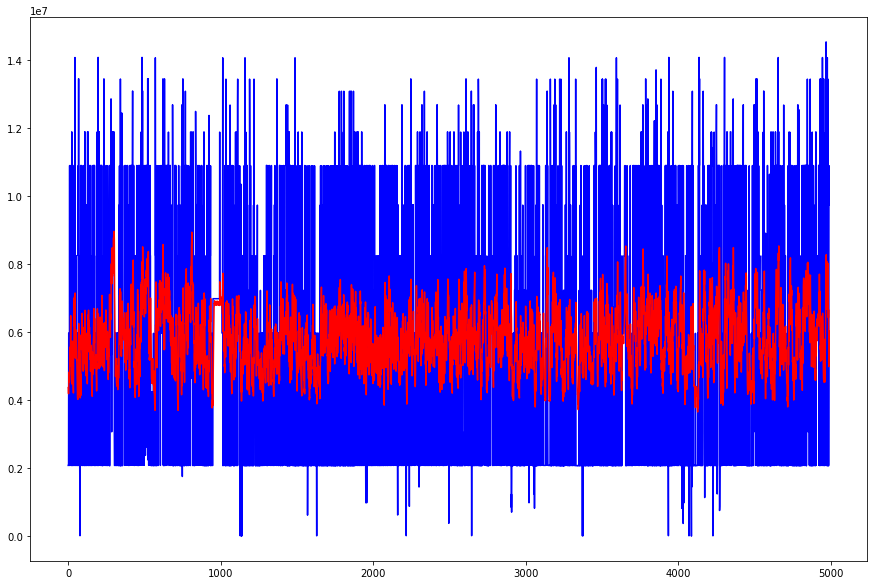

In [48]:
plt.figure(figsize=(15,10))
plt.plot(df_result['Actual'], color='blue')
plt.plot(df_result['Prediction'], color='red')
plt.show()